In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as optimize

In [2]:
def chisq(obs, exp, error):
    return np.sum(np.square(obs - exp) / np.square(error))

We will first try with the usual broken power law:

In [3]:
def br_po_lw(E, E1, fl_0, lam1, sqrtdelta_lam12):
    polw = np.zeros(len(E))
    lam2 = lam1 + sqrtdelta_lam12**2 #for multiple broken power law add lam_i = lam_(i-1) + delta_lam
    phi_0 = fl_0 * E[0]**lam1
    phi_1 = phi_0 * (E1 ** (sqrtdelta_lam12))
    for i in range(len(E)):
        if E[i] < E1:#you can add E>E0
            polw[i] = phi_0 * (E[i] ** (-lam1))
        else:#you can add elifs for multiple broken power law
            polw[i] = phi_1 * (E[i] ** (-lam2))
    return polw

Now let's add the $\chi^2$ to the function in order to minimize:

In [4]:
def br_po_lw_chsq(params): 
    #you need to define theE, SED and SED_u before(E and SED must be a numpy.array and SED an scalar or a numpy.array)
    E1, fl_0, lam1, sqrtdelta_lam12 = params
    polw = np.zeros(len(E))
    lam2 = lam1 + sqrtdelta_lam12**2 #for multiple broken power law add lam_i = lam_(i-1) + delta_lam
    phi_0 = fl_0 * E[0]**lam1
    phi_1 = phi_0 * (E1 ** (sqrtdelta_lam12))
    for i in range(len(E)):
        if E[i] < E1:#you can add E>E0
            polw[i] = phi_0 * (E[i] ** (-lam1))
        else:#you can add elifs for multiple broken power law
            polw[i] = phi_1 * (E[i] ** (-lam2))
    return np.sum(np.square(SED - polw) / np.square(SED_u))

Let's show an example:

In [5]:
initial_guess = [2, 9, 0.9, 1.3]
E = [1, 2, 2.99, 3, 4, 8, 25]
E_test = [1, 2, 2.99, 3, 4, 8, 25]
SED = br_po_lw(E=E_test, E1=3, fl_0=10, lam1=1, sqrtdelta_lam12=1)
SED_u = 0.1 * SED

result = optimize.minimize(br_po_lw_chsq, initial_guess, method = 'Nelder-Mead')
if result.success:
    fitted_params = result.x
    print(fitted_params)
else:
    raise ValueError(result.message)

[ 3.00001897 10.00004798  0.99999936  1.0000028 ]


After getting the parameters, just use the original br_po_lw function with those parameters to get the fit:

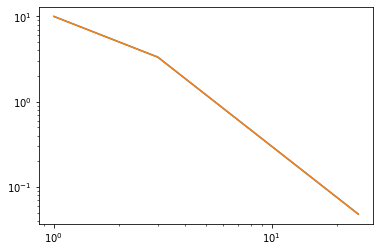

In [6]:
SED_fit = br_po_lw(E_test, result.x[0], result.x[1], result.x[2], result.x[3])

plt.plot(E_test, SED, label='original')
plt.plot(E_test, SED_fit, label='fit')
plt.xscale('log')
plt.yscale('log')
plt.show()

Let's check the difference between the fit and the original one (in log scale)

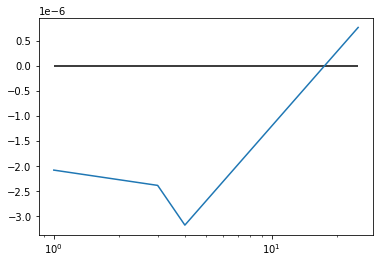

In [7]:
diff = np.log10(SED) - np.log10(SED_fit)
plt.plot(E_test, diff)
plt.xscale('log')
plt.hlines(0, xmin=min(E_test), xmax=max(E_test), color = 'black')

Now let's try to minimize with iminuit

In [10]:
from iminuit import Minuit

In [11]:
br_po_lw_chsq.errordef = Minuit.LIKELIHOOD

m = Minuit(br_po_lw_chsq, initial_guess)

m.migrad()
print(m.values)

m.hesse()
print(m.errors)

<ValueView x0=2.9999311612948607 x1=9.995830430823746 x2=0.9994858591140281 x3=1.0002205044972565>
<ErrorView x0=0.243451828151753 x1=0.6751477855161859 x2=0.0902227318118413 x3=0.05002024778857368>


In [13]:
print(m.values)
print(fitted_params)

<ValueView x0=2.9999311612948607 x1=9.995830430823746 x2=0.9994858591140281 x3=1.0002205044972565>
[ 3.00001897 10.00004798  0.99999936  1.0000028 ]


We can see that Minuit is better than scipy.optimize.minimize as it gives a better result, accepts different params instead of a parameter in an array and the result gives an uncertainty with it too. 